Things to cover in this section:

✔️ Train, tune and use time series, sequence and prediction models.  
✔️ Prepare data for time series learning.  
✔️ Understand Mean Average Error (MAE) and how it can be used to evaluate accuracy of sequence models.  
  Use RNNs and CNNs for time series, sequence and forecasting models.  
✔️ Identify when to use trailing versus centred windows.  
  Use TensorFlow for forecasting.  
✔️ Prepare features and labels.  
  Identify and compensate for sequence bias.  
  Adjust the learning rate dynamically in time series, sequence and prediction models.  

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from dateutil.relativedelta import *
import datetime

import tensorflow as tf

from pathlib import Path
import os

## Prepare data for time series learning.  

In [12]:
home = str(Path.home())
base_dir = os.path.join(home, 'datasets/')
data_dir = os.path.join(base_dir, 'sunspot.csv')
sunspot = pd.read_csv(data_dir)
series = np.array(sunspot.x.to_list())

In [14]:
date_str = '1749-01-01' # Start date
format_str = '%Y-%m-%d' # The format
start_date = datetime.datetime.strptime(date_str, format_str)

In [15]:
dates = [start_date+relativedelta(months=+i) for i in range(3177)]

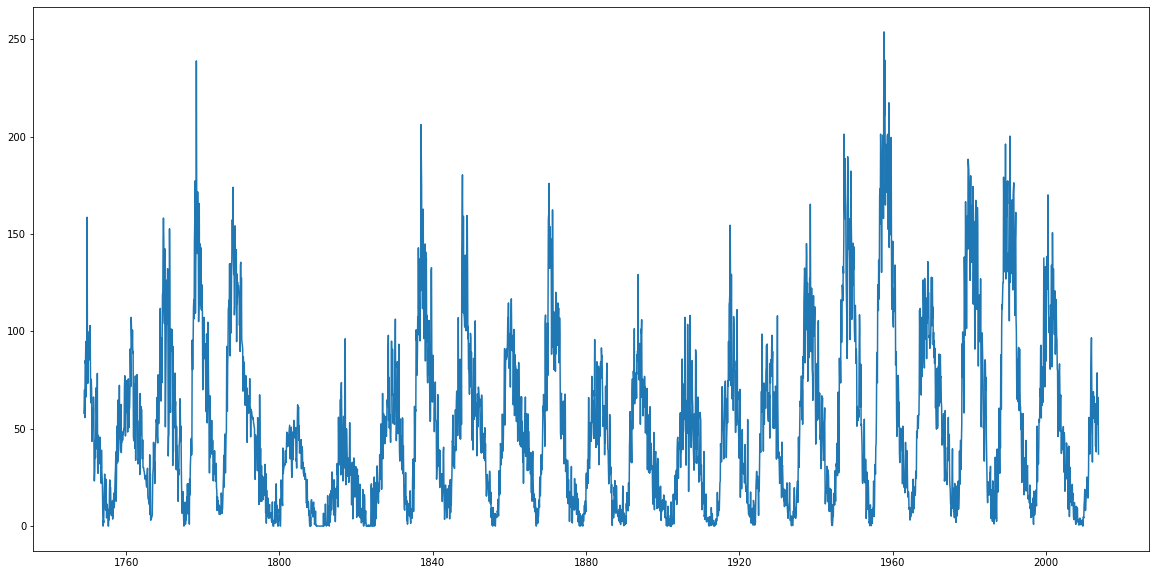

In [16]:
plt.figure(figsize=(20,10))
plt.plot(dates, series)

## Prepare features and labels.  

In [17]:
dataset = tf.data.Dataset.range(12)

dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)

In [18]:
for x, y in dataset:
    print('x = ', x.numpy())
    print('y = ', y.numpy())

x =  [[0 1 2 3]
 [1 2 3 4]]
y =  [[4]
 [5]]
x =  [[2 3 4 5]
 [3 4 5 6]]
y =  [[6]
 [7]]
x =  [[6 7 8 9]
 [4 5 6 7]]
y =  [[10]
 [ 8]]
x =  [[ 5  6  7  8]
 [ 7  8  9 10]]
y =  [[ 9]
 [11]]


## Train (✔️), tune and use time series, sequence and prediction models.
This will be like a simple linear regression.

In [21]:
window_size = 60
batch_size = 2
split_time = 1000
shuffle_buffer_size=10

In [22]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)

In [23]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])

In [24]:
model = tf.keras.models.Sequential([l0])

In [25]:
model.compile(loss='mae', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

In [28]:
model.fit(dataset, epochs=10, verbose=1)

Epoch 1/10
1559/1559 [==============================] - 6s 4ms/step - loss: 12.4839
Epoch 2/10
1559/1559 [==============================] - 3s 2ms/step - loss: 12.1740
Epoch 3/10
1559/1559 [==============================] - 3s 2ms/step - loss: 12.0585
Epoch 4/10
1559/1559 [==============================] - 3s 2ms/step - loss: 11.8752
Epoch 5/10
1559/1559 [==============================] - 3s 2ms/step - loss: 11.7624
Epoch 6/10
1559/1559 [==============================] - 3s 2ms/step - loss: 11.7735
Epoch 7/10
1559/1559 [==============================] - 4s 2ms/step - loss: 11.6655
Epoch 8/10
1559/1559 [==============================] - 4s 2ms/step - loss: 11.5169
Epoch 9/10
1559/1559 [==============================] - 3s 2ms/step - loss: 11.4907
Epoch 10/10
1559/1559 [==============================] - 3s 2ms/step - loss: 11.5430


In [29]:
l0.get_weights()

[array([[ 5.2827183e-02],
        [ 9.0081356e-03],
        [-7.8228582e-03],
        [ 1.0945982e-03],
        [ 1.1170050e-02],
        [-2.4286214e-02],
        [ 2.7738137e-02],
        [-2.4138479e-02],
        [ 3.6091141e-02],
        [-2.0182743e-03],
        [-3.3852845e-02],
        [ 1.3374078e-02],
        [-4.7175530e-02],
        [ 1.5849043e-02],
        [ 3.8990281e-03],
        [-1.4793461e-02],
        [ 4.4837005e-02],
        [-4.6598263e-02],
        [ 1.0288341e-02],
        [-1.0461715e-02],
        [-1.7789293e-02],
        [ 1.9693950e-02],
        [-8.2829837e-03],
        [-4.8062089e-03],
        [ 7.4641891e-03],
        [-4.8254952e-02],
        [-7.7603455e-03],
        [-2.5923787e-02],
        [ 1.8751059e-02],
        [ 1.3302716e-02],
        [ 9.9817719e-03],
        [-1.9138362e-02],
        [-3.2288998e-02],
        [-3.8788304e-02],
        [ 1.5037566e-02],
        [ 4.6524435e-02],
        [-4.7256850e-02],
        [ 6.4493313e-02],
        [-2.

In [30]:
model.predict(series[0:window_size][np.newaxis])

array([[11.050576]], dtype=float32)

In [31]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

In [32]:
forecasted = [i[0][0] for i in forecast]

In [33]:
forecasted = forecasted[split_time-window_size:]

In [34]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [35]:
len(forecasted)

2177

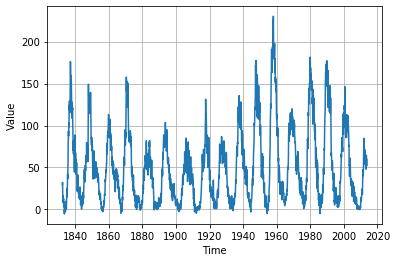

In [36]:
plot_series(dates[split_time:], forecasted)

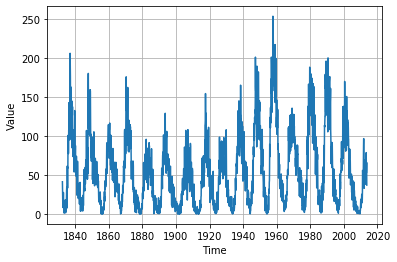

In [37]:
plot_series(dates[split_time:], series[split_time:])

## Understand Mean Average Error (MAE) and how it can be used to evaluate accuracy of sequence models.  

In [38]:
x_valid = series[split_time:]
results = forecasted

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

12.150665